In [13]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

DATA_DIR = Path("..") / "data" / "processed"
VAULT_PATH = DATA_DIR / "vault_hourly.parquet"
MARKET_PATH = DATA_DIR / "market_weighted_features.parquet"


# **Load data**

In [14]:
def _load_parquet(path: Path) -> pd.DataFrame:
    """Load a parquet file with a helpful error message."""
    if not path.exists():
        raise FileNotFoundError(f"Missing file: {path.resolve()}")
    return pd.read_parquet(path)

vault_hourly_df = _load_parquet(VAULT_PATH)
market_features_df = _load_parquet(MARKET_PATH)

print("vault_hourly_df:", vault_hourly_df.shape)
display(vault_hourly_df.head(3))

print("market_features_df:", market_features_df.shape)
display(market_features_df.head(3))


vault_hourly_df: (168, 8)


,timestamp,total_assets_raw,total_supply_raw,apy,net_apy,total_assets,share_price,tvl_usdc_proxy
0,2026-01-07 20:00:00+00:00,1.329028e+14,1.218731e+26,0.053597,0.056653,1.329028e+08,1.090502,1.329028e+08
1,2026-01-07 21:00:00+00:00,1.329037e+14,1.218731e+26,0.052956,0.056040,1.329037e+08,1.090509,1.329037e+08
2,2026-01-07 22:00:00+00:00,1.335527e+14,1.224675e+26,0.051715,0.054801,1.335527e+08,1.090515,1.335527e+08


market_features_df: (168, 5)


,timestamp,weighted_utilization,weighted_supply_apy,weighted_borrow_apy,alloc_snapshot_ts
0,2026-01-07 20:00:00+00:00,0.874972,0.052549,0.060189,1768418116
1,2026-01-07 21:00:00+00:00,0.883596,0.052284,0.059329,1768418116
2,2026-01-07 22:00:00+00:00,0.893098,0.055305,0.062058,1768418116


# **Normalize timestamps & merge**

In [15]:
def _ensure_hourly_utc(df: pd.DataFrame, ts_col: str = "timestamp") -> pd.DataFrame:
    """Ensure timestamp column is tz-aware UTC and floored to hour."""
    out = df.copy()
    out[ts_col] = pd.to_datetime(out[ts_col], utc=True).dt.floor("h")
    return out

vault_hourly_df = _ensure_hourly_utc(vault_hourly_df, "timestamp")
market_features_df = _ensure_hourly_utc(market_features_df, "timestamp")

eda_df = (
    vault_hourly_df.merge(market_features_df, on="timestamp", how="left")
    .sort_values("timestamp")
    .reset_index(drop=True)
)

print("eda_df:", eda_df.shape)
display(eda_df.head(5))


eda_df: (168, 12)


,timestamp,total_assets_raw,total_supply_raw,apy,net_apy,total_assets,share_price,tvl_usdc_proxy,weighted_utilization,weighted_supply_apy,weighted_borrow_apy,alloc_snapshot_ts
0,2026-01-07 20:00:00+00:00,1.329028e+14,1.218731e+26,0.053597,0.056653,1.329028e+08,1.090502,1.329028e+08,0.874972,0.052549,0.060189,1768418116
1,2026-01-07 21:00:00+00:00,1.329037e+14,1.218731e+26,0.052956,0.056040,1.329037e+08,1.090509,1.329037e+08,0.883596,0.052284,0.059329,1768418116
2,2026-01-07 22:00:00+00:00,1.335527e+14,1.224675e+26,0.051715,0.054801,1.335527e+08,1.090515,1.335527e+08,0.893098,0.055305,0.062058,1768418116
3,2026-01-07 23:00:00+00:00,1.335535e+14,1.224675e+26,0.051952,0.055060,1.335535e+08,1.090522,1.335535e+08,0.885597,0.052565,0.059503,1768418116
4,2026-01-08 00:00:00+00:00,1.335542e+14,1.224675e+26,0.058789,0.061876,1.335542e+08,1.090528,1.335542e+08,0.878500,0.052556,0.059967,1768418116


# **Data quality checks (duplicates, missing hours, missing values)**

In [45]:
def _hourly_gaps(df: pd.DataFrame, ts_col: str = "timestamp") -> pd.DataFrame:
    """Return missing hourly timestamps between min/max."""
    ts = pd.to_datetime(df[ts_col], utc=True).sort_values()
    full = pd.date_range(ts.min(), ts.max(), freq="h", tz="UTC")
    missing = full.difference(ts)
    return pd.DataFrame({"missing_timestamp": missing})

# Duplicates
dup_count = eda_df["timestamp"].duplicated().sum()
print("Duplicate timestamps:", dup_count)

# Missing hours
missing_hours_df = _hourly_gaps(eda_df)
print("Missing hours:", len(missing_hours_df))
display(missing_hours_df.head(10))

# Missing values summary
missing_pct = (eda_df.isna().mean() * 100).sort_values(ascending=False)
display(missing_pct.to_frame("missing_%").head(20))


Duplicate timestamps: 0
Missing hours: 0


,missing_timestamp


,missing_%
return_24h,14.285714
timestamp,0.000000
total_assets_raw,0.000000
total_supply_raw,0.000000
apy,0.000000
net_apy,0.000000
total_assets,0.000000
share_price,0.000000
tvl_usdc_proxy,0.000000
weighted_utilization,0.000000


# **Target engineering: 24h ahead return**

In [46]:
def add_target_return_24h(df: pd.DataFrame, price_col: str = "share_price") -> pd.DataFrame:
    """Add 24h ahead return: (P[t+24]-P[t])/P[t]."""
    out = df.copy()
    out["return_24h"] = (out[price_col].shift(-24) - out[price_col]) / out[price_col]
    return out

eda_df = add_target_return_24h(eda_df, "share_price")

print("return_24h nulls (expected at tail):", eda_df["return_24h"].isna().sum())
display(eda_df.head(50))

return_24h nulls (expected at tail): 24


,timestamp,total_assets_raw,total_supply_raw,apy,net_apy,total_assets,share_price,tvl_usdc_proxy,weighted_utilization,weighted_supply_apy,weighted_borrow_apy,alloc_snapshot_ts,return_24h
0,2026-01-07 20:00:00+00:00,1.329028e+14,1.218731e+26,0.053597,0.056653,1.329028e+08,1.090502,1.329028e+08,0.874972,0.052549,0.060189,1768418116,0.000140
1,2026-01-07 21:00:00+00:00,1.329037e+14,1.218731e+26,0.052956,0.056040,1.329037e+08,1.090509,1.329037e+08,0.883596,0.052284,0.059329,1768418116,0.000139
2,2026-01-07 22:00:00+00:00,1.335527e+14,1.224675e+26,0.051715,0.054801,1.335527e+08,1.090515,1.335527e+08,0.893098,0.055305,0.062058,1768418116,0.000139
3,2026-01-07 23:00:00+00:00,1.335535e+14,1.224675e+26,0.051952,0.055060,1.335535e+08,1.090522,1.335535e+08,0.885597,0.052565,0.059503,1768418116,0.000139
4,2026-01-08 00:00:00+00:00,1.335542e+14,1.224675e+26,0.058789,0.061876,1.335542e+08,1.090528,1.335542e+08,0.878500,0.052556,0.059967,1768418116,0.000140
5,2026-01-08 01:00:00+00:00,1.335551e+14,1.224675e+26,0.051756,0.054875,1.335551e+08,1.090534,1.335551e+08,0.877748,0.057887,0.065709,1768418116,0.000141
6,2026-01-08 02:00:00+00:00,1.335490e+14,1.224613e+26,0.050875,0.053970,1.335490e+08,1.090541,1.335490e+08,0.864354,0.051903,0.060102,1768418116,0.000141
7,2026-01-08 03:00:00+00:00,1.335658e+14,1.224759e+26,0.047486,0.050553,1.335658e+08,1.090547,1.335658e+08,0.850121,0.051036,0.060022,1768418116,0.000141
8,2026-01-08 04:00:00+00:00,1.335659e+14,1.224754e+26,0.047684,0.050733,1.335659e+08,1.090553,1.335659e+08,0.843705,0.047976,0.057057,1768418116,0.000142
9,2026-01-08 05:00:00+00:00,1.335166e+14,1.224295e+26,0.048896,0.051954,1.335166e+08,1.090559,1.335166e+08,0.845883,0.048173,0.057146,1768418116,0.000143


# **Visual sanity: share price & target distribution**

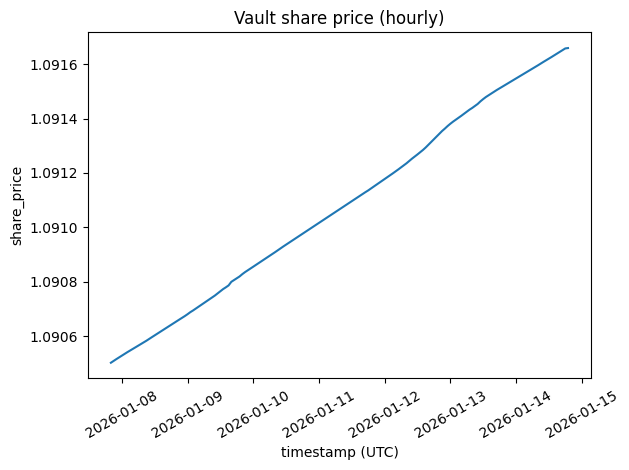

In [29]:
plt.figure()
plt.plot(eda_df["timestamp"], eda_df["share_price"])
plt.title("Vault share price (hourly)")
plt.xlabel("timestamp (UTC)")
plt.ylabel("share_price")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

>##### The vault share price exhibits a smooth, strictly increasing trajectory over time, consistent with interest accrual mechanics in lending vaults. This confirms the correctness of share price computation and scale. However, the non-stationary nature of the level series indicates that modeling the raw share price would be uninformative. Consequently, we define the prediction target as the hourly return of the share price, which captures the economically meaningful yield dynamics and is better suited for time-series modeling.

# **Histogram of target**

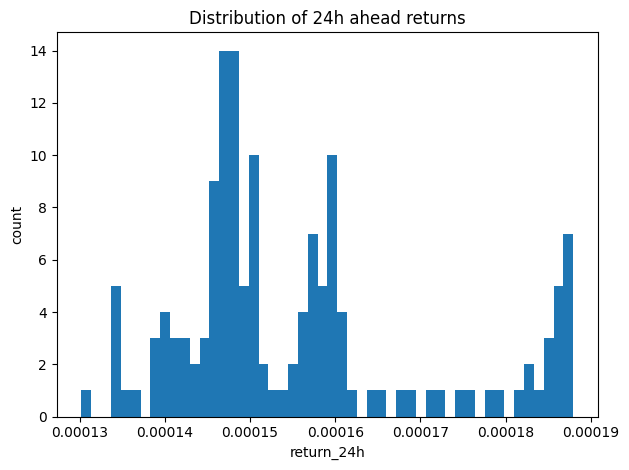

return_24h summary:


,count,mean,std,min,1%,5%,50%,95%,99%,max
return_24h,144.0,0.000156,0.000015,0.00013,0.000134,0.000137,0.00015,0.000186,0.000188,0.000188


skew: 0.9416487911400688 kurtosis: 0.002437904924490919


In [35]:
target = eda_df["return_24h"].dropna()

plt.figure()
plt.hist(target, bins=50)
plt.title("Distribution of 24h ahead returns")
plt.xlabel("return_24h")
plt.ylabel("count")
plt.tight_layout()
plt.show()

print("return_24h summary:")
display(target.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).to_frame().T)
print("skew:", float(target.skew()), "kurtosis:", float(target.kurtosis()))

>##### The 24h return distribution is tightly concentrated and strictly positive, with a mean of 0.0001556 (≈ 1.56 bps) and a low standard deviation of 1.47e-05, indicating very stable returns. Values lie in a narrow range with limited dispersion. The distribution shows a moderate positive skew (0.94), suggesting occasional higher upside moves, and near-zero kurtosis (0.00), indicating no heavy tails or extreme events. This confirms that vault returns are smooth, carry-driven, and dominated by slow interest-rate dynamics rather than volatility.

# **Feature behavior: timeseries + rolling stats**

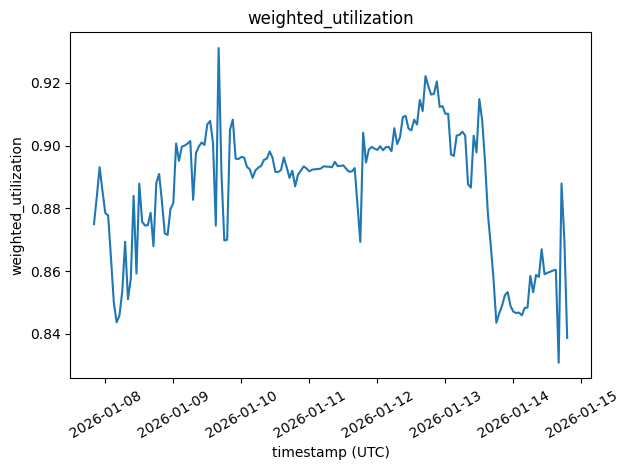

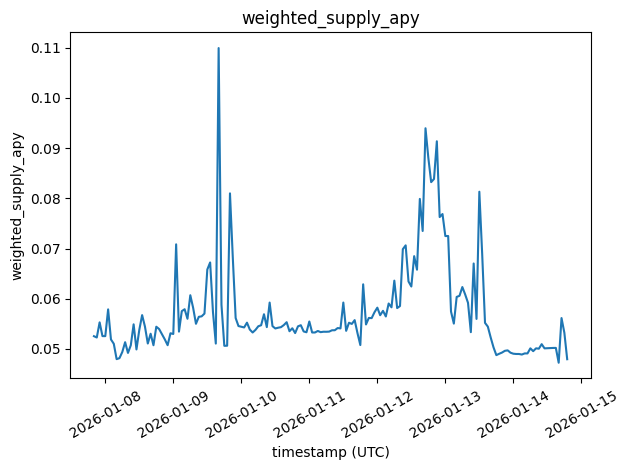

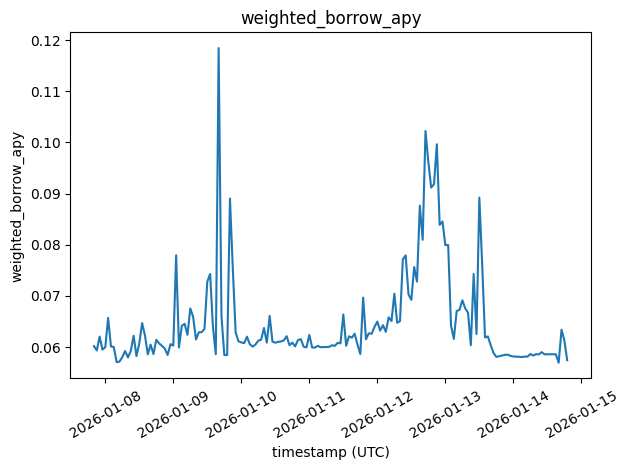

In [37]:
feature_cols = ["weighted_utilization", "weighted_supply_apy", "weighted_borrow_apy"]

for col in feature_cols:
    if col not in eda_df.columns:
        print(f"Missing feature col: {col}")
        continue
    plt.figure()
    plt.plot(eda_df["timestamp"], eda_df[col])
    plt.title(col)
    plt.xlabel("timestamp (UTC)")
    plt.ylabel(col)
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

> 1. **Weighted utilization:**
the weighted utilization remains structurally high (≈0.88–0.92) with occasional sharp drops, indicating a persistently capital-constrained vault punctuated by short-lived liquidity events.

> 2. **Weighted borrow APY:**
the weighted borrow APY is mostly stable around ~6%, but exhibits abrupt spikes up to ~12%, reflecting episodic liquidity stress and non-linear market dynamics.

> 3. **Weighted supply APY:**
the weighted supply APY closely tracks the borrow APY with lower amplitude, confirming its role as the direct transmission channel from market conditions to vault yield.

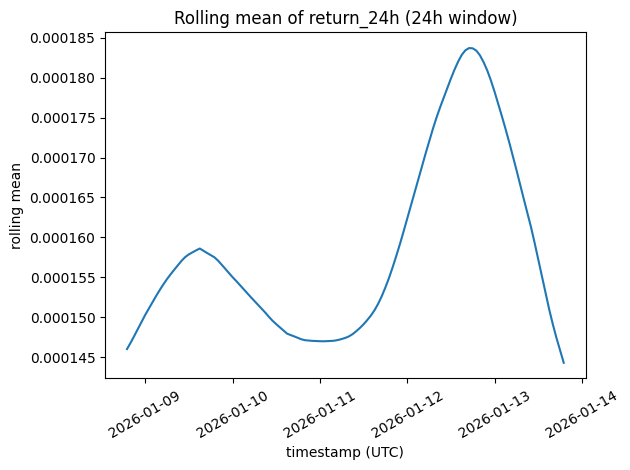

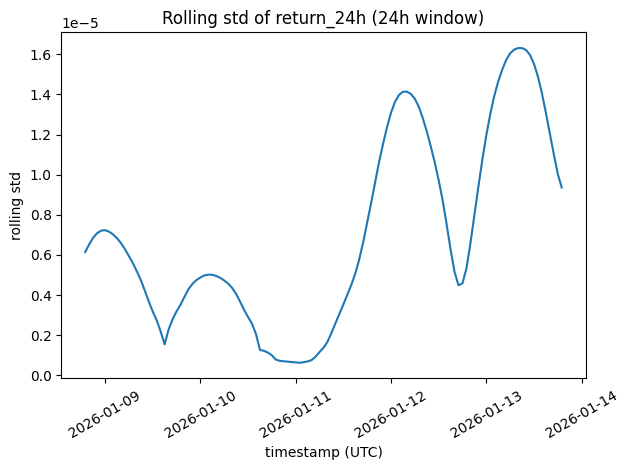

In [38]:
window = 24  # 24 hours
tmp = eda_df.copy()
tmp["return_24h_mean_24h"] = tmp["return_24h"].rolling(window).mean()
tmp["return_24h_std_24h"] = tmp["return_24h"].rolling(window).std()

plt.figure()
plt.plot(tmp["timestamp"], tmp["return_24h_mean_24h"])
plt.title("Rolling mean of return_24h (24h window)")
plt.xlabel("timestamp (UTC)")
plt.ylabel("rolling mean")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(tmp["timestamp"], tmp["return_24h_std_24h"])
plt.title("Rolling std of return_24h (24h window)")
plt.xlabel("timestamp (UTC)")
plt.ylabel("rolling std")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

>**Rolling mean of 24h returns (24h window)**
the rolling mean of 24-hour returns captures the recent average performance of the vault. Its time variation highlights regime changes, with a period of elevated expected returns around January 12–13 followed by a decline, indicating that returns are non-stationary and time-dependent.

>**Rolling standard deviation of 24h returns (24h window)**
the rolling standard deviation of 24-hour returns measures local return volatility. The presence of pronounced volatility spikes indicates heteroskedastic behavior and distinct risk regimes, suggesting that predictive uncertainty varies over time.

# Autocorrelation

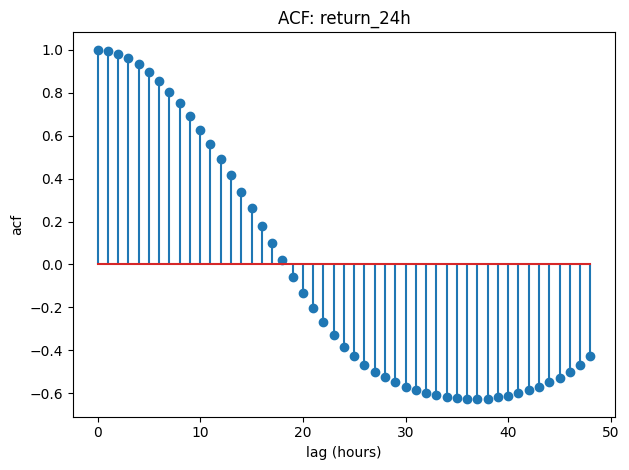

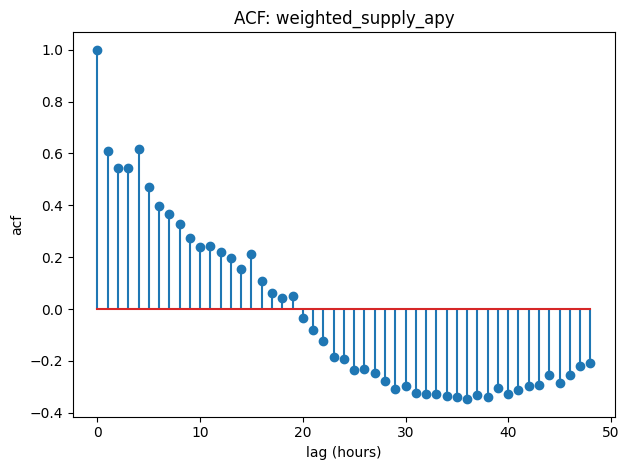

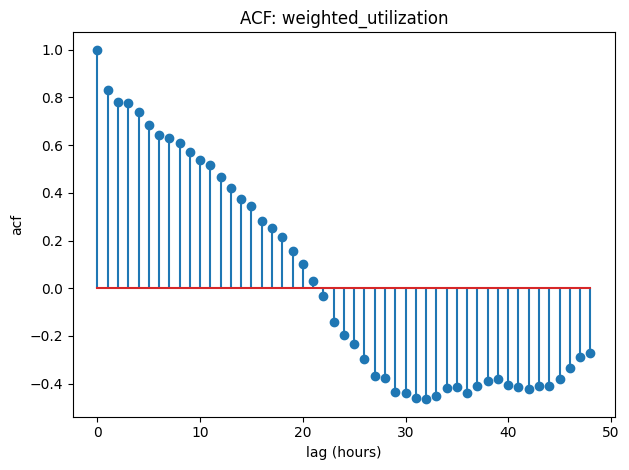

In [39]:
def autocorr(series: pd.Series, max_lag: int) -> pd.DataFrame:
    """Compute autocorrelation up to max_lag (inclusive)."""
    s = series.dropna().astype(float)
    acf_vals = []
    for lag in range(0, max_lag + 1):
        acf_vals.append(s.autocorr(lag=lag))
    return pd.DataFrame({"lag": range(0, max_lag + 1), "acf": acf_vals})

max_lag = 48  # 2 days
acf_target = autocorr(eda_df["return_24h"], max_lag=max_lag)

plt.figure()
plt.stem(acf_target["lag"], acf_target["acf"])
plt.title("ACF: return_24h")
plt.xlabel("lag (hours)")
plt.ylabel("acf")
plt.tight_layout()
plt.show()

for col in ["weighted_supply_apy", "weighted_utilization"]:
    if col not in eda_df.columns:
        continue
    acf_feat = autocorr(eda_df[col], max_lag=max_lag)
    plt.figure()
    plt.stem(acf_feat["lag"], acf_feat["acf"])
    plt.title(f"ACF: {col}")
    plt.xlabel("lag (hours)")
    plt.ylabel("acf")
    plt.tight_layout()
    plt.show()


>The very high short-lag autocorrelation (>0.9) observed in the 24h return is a direct consequence of the overlapping rolling window used to construct the target. Consecutive observations share most of their underlying data, creating artificial persistence. This implies that a naive predictor using the current value would already achieve strong performance, and special care must be taken to avoid temporal leakage during model validation.

# **Feature → target relationship (correlations + lag scan)**

In [40]:
analysis_df = eda_df.dropna(subset=["return_24h"]).copy()

corr_cols = ["return_24h"] + [c for c in feature_cols if c in analysis_df.columns]
corr_matrix = analysis_df[corr_cols].corr()

display(corr_matrix)

,return_24h,weighted_utilization,weighted_supply_apy,weighted_borrow_apy
return_24h,1.000000,0.435048,0.288588,0.267322
weighted_utilization,0.435048,1.000000,0.726003,0.678547
weighted_supply_apy,0.288588,0.726003,1.000000,0.997728
weighted_borrow_apy,0.267322,0.678547,0.997728,1.000000


>The correlation analysis shows that weighted utilization has the strongest relationship with the 24h return (ρ ≈ 0.44), suggesting it captures meaningful economic signal for vault performance. Supply and borrow APYs exhibit weaker direct correlations with the target and are almost perfectly collinear with each other (ρ ≈ 0.998), indicating severe multicollinearity. This implies that utilization is the most informative standalone feature, while APY variables should be carefully reduced or transformed before modeling.

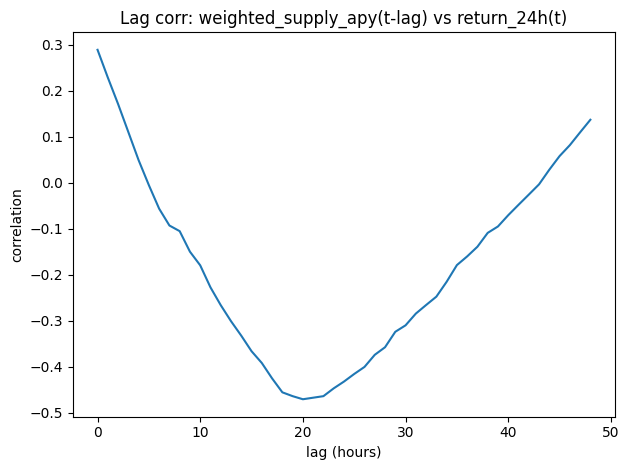

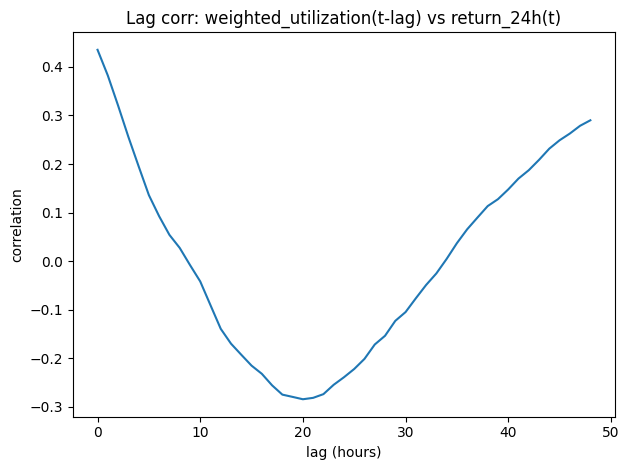

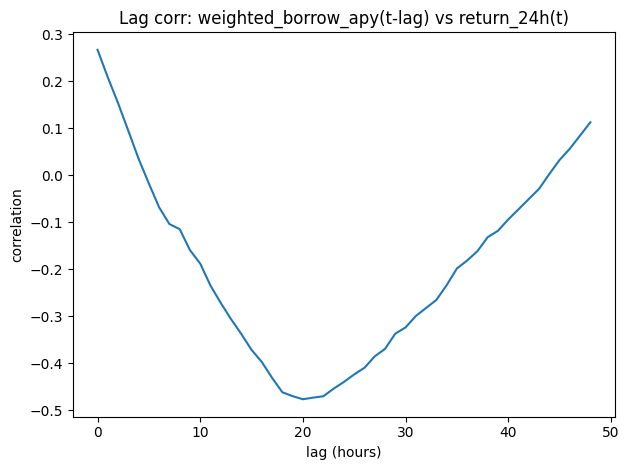

In [43]:
def lag_correlation(
    df: pd.DataFrame,
    feature: str,
    target: str,
    lags: range,
) -> pd.DataFrame:
    """
    Compute corr(feature shifted by lag, target).
    lag > 0 means feature is from the past: feature[t-lag] vs target[t]
    """
    rows = []
    base = df[[feature, target]].dropna().copy()
    for lag in lags:
        shifted = base[feature].shift(lag)
        corr = pd.concat([shifted, base[target]], axis=1).dropna().corr().iloc[0, 1]
        rows.append({"lag_hours": lag, "corr": corr})
    return pd.DataFrame(rows)

lags = range(0, 49)  # 0..48 hours back
for feat in ["weighted_supply_apy", "weighted_utilization", "weighted_borrow_apy"]:
    if feat not in analysis_df.columns:
        continue
    lag_corr_df = lag_correlation(analysis_df, feature=feat, target="return_24h", lags=lags)

    plt.figure()
    plt.plot(lag_corr_df["lag_hours"], lag_corr_df["corr"])
    plt.title(f"Lag corr: {feat}(t-lag) vs return_24h(t)")
    plt.xlabel("lag (hours)")
    plt.ylabel("correlation")
    plt.tight_layout()
    plt.show()


>Lagged correlations show a strong positive relationship at short lags and a pronounced negative dip around 18–24 hours for all features. This symmetric “U-shaped” pattern is mainly a mathematical artifact of the overlapping 24h rolling return, not true market causality.

>Among the features, weighted utilization exhibits the strongest and most consistent signal, while supply and borrow APYs appear largely redundant. Overall, the lag scan highlights a high risk of spurious predictability and the need for careful lag selection and validation.

### Key EDA Findings

**Share price & target definition**
The vault share price follows a smooth, strictly increasing trajectory, consistent with interest accrual mechanics. This validates the share price computation but confirms that the level series is non-stationary and uninformative for modeling. As a result, the prediction target is defined as the 24h rolling return, which captures economically meaningful yield dynamics.

**24h return distribution**
The 24h return distribution is tightly concentrated and strictly positive, with a mean of 0.0001556 (≈1.56 bps) and a low standard deviation of 1.47e-05. Returns exhibit moderate positive skew (0.94) and near-zero kurtosis (≈0.00), indicating stable, carry-driven behavior with limited tail risk and no extreme events.

**Underlying market features**
Weighted utilization remains structurally high (≈0.88–0.92), indicating a persistently capital-constrained vault, with occasional sharp drops corresponding to short-lived liquidity events. Weighted borrow APY is generally stable around ~6% but displays abrupt spikes up to ~12%, reflecting episodic liquidity stress. Weighted supply APY closely tracks borrow APY with lower amplitude, confirming it as the transmission channel from market conditions to vault yield.

**Temporal dynamics (rolling statistics)**
The rolling mean of 24h returns (24h window) reveals time-varying regimes, with periods of elevated expected returns followed by normalization. The rolling standard deviation highlights heteroskedastic behavior, with volatility spikes indicating changing risk regimes and non-constant predictive uncertainty.

**Autocorrelation & target construction**
The 24h return exhibits extremely high short-lag autocorrelation (>0.9), caused by the overlapping rolling window used to construct the target. Consecutive observations share most of their underlying data, creating artificial persistence. This introduces a high risk of data leakage and implies that naive predictors can perform well without learning true economic dynamics.

**Correlation & lag analysis**
Contemporaneous correlations show that weighted utilization has the strongest relationship with the target (ρ ≈ 0.44), making it the most informative feature. Supply and borrow APYs have weaker direct correlations and are almost perfectly collinear with each other (ρ ≈ 0.998), indicating severe multicollinearity. Lagged correlation scans display a symmetric U-shaped pattern with a negative dip around 18–24h, largely a mathematical artifact of the overlapping return definition rather than causal market effects.

---

### Identified Challenges & Limitations

- Strong autocorrelation and overlapping-window effects create spurious predictability.
- High multicollinearity between supply and borrow APYs limits their standalone usefulness.
- Non-stationary return regimes and time-varying volatility require careful validation.
- Model evaluation must use time-aware splits with appropriate gaps to avoid leakage.